In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def load_image(path):
    return np.array(Image.open(path))

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]

def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

def normalize(x, rgb_mean=DIV2K_RGB_MEAN): #normalizing image
    return (x - rgb_mean) / 127.5

def denormalize(x, rgb_mean=DIV2K_RGB_MEAN): #denormalizing image
    return x * 127.5 + rgb_mean

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None): #creates an EDSR model
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x) #convolutional layer
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling) #residual blocks
    b = Conv2D(num_filters, 3, padding='same')(b) #convolutional layer
    x = Add()([x, b])

    x = upsample(x, scale, num_filters) #upsampling image
    x = Conv2D(3, 3, padding='same')(x) #convolutional layer

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")

def res_block(x_in, filters, scaling): #creates an EDSR residual block
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in) #convolutional network with relu activation block
    x = Conv2D(filters, 3, padding='same')(x) #convolutional layer
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters): #sub-pixel convolution
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2: #upsample depending on scale given
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

%matplotlib inline

def resolve_and_plot(model_pre_trained, model_fine_tuned, lr_image_path):
    lr = load_image(lr_image_path)
    
    sr_pt = resolve_single(model_pre_trained, lr) #applying edsr pretrained weights to enhance image
    sr_ft = resolve_single(model_fine_tuned, lr) #fine tuning output image with pretrained srgan weights

    sr_ft = np.array(sr_ft)
    cv2.imwrite("srimage.png",cv2.cvtColor(sr_ft, cv2.COLOR_RGB2BGR))
    
    plt.figure(figsize=(20, 20))
    
    model_name = model_pre_trained.name.upper()
    images = [lr, sr_pt, sr_ft]
    titles = ['Original image', f'SR ({model_name}, pixel loss)', f'SR ({model_name}, perceptual loss)']
    positions = [1, 3, 4]
    
    for i, (image, title, position) in enumerate(zip(images, titles, positions)): #displaying output images
        plt.subplot(2, 2, position)
        plt.imshow(image)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        
weights_dir = ''

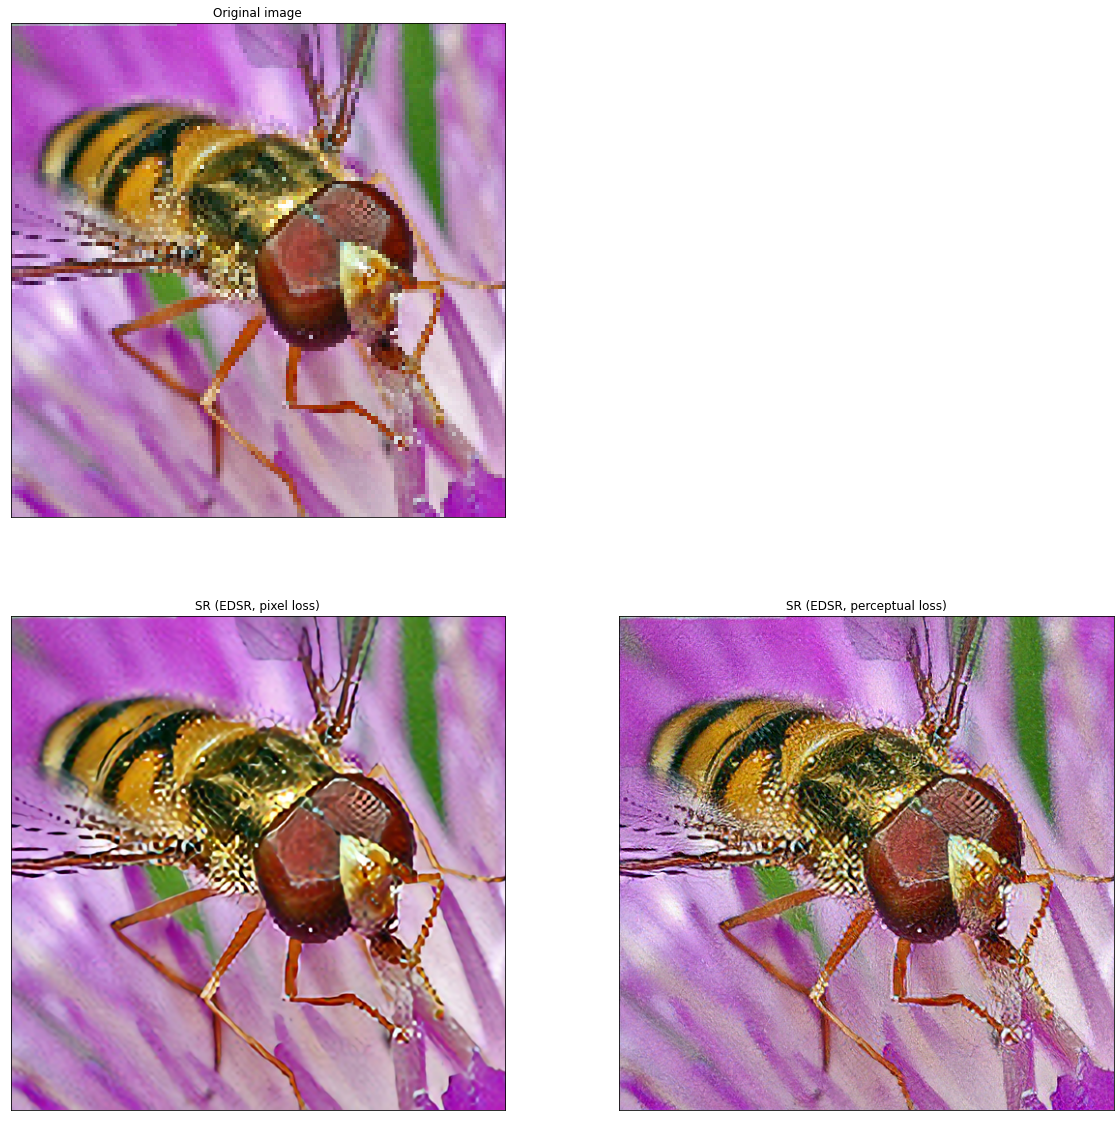

In [ ]:
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5')) #calling edsr pretrained weights

edsr_fine_tuned = edsr(scale=4, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5')) #calling srgan pretrained weights

resolve_and_plot(edsr_pre_trained, edsr_fine_tuned, 'secret_image.png') #secret image as input